In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp

In [2]:
# Constants
gravConst = 4.302e-6  # M_sun^-1 (km/s)^2 kpc
R_sun = 8.0  # kpc
GeVcm3_to_Msunkpc3 = 2.685e7  # GeV/cm^3 to M_sun/kpc^3
Msunpc2_to_Msunkpc2 = 1.0e6  # M_sun/pc^2 to M_sun/kpc^2

In [3]:
def v_NFW(Rho_sun, Rs, r):
    """NFW velocity profile."""
    Rhos = (Rho_sun * GeVcm3_to_Msunkpc3) * (R_sun / Rs) * (1 + (R_sun / Rs))**2
    gr = np.log(np.maximum((Rs + r) / Rs, 1e-10)) - (r / (Rs + r + 1e-10))
    mass = 4.0 * np.pi * Rhos * gr * Rs**3
    return np.sqrt(gravConst * mass / np.maximum(r, 1e-10))

def v_EXP(sigma_sun, Rb, r):
    """Thin exponential disc velocity profile."""
    Sigmab = (sigma_sun * Msunpc2_to_Msunkpc2) * np.exp(R_sun / Rb)
    mb = 2.0 * np.pi * Rb**2 * Sigmab
    y = r / (2.0 * Rb)
    vsq = 2.0 * gravConst * (mb / Rb) * (y**2) * (sp.i0(y) * sp.k0(y) - sp.i1(y) * sp.k1(y))
    if np.any(np.isnan(vsq)):  # Corrected line
        return 0.0  # Handle NaN values.
    if np.any(vsq < 0): # handles negative values in vsq.
        return 0.0
    return np.sqrt(np.abs(vsq))

def v_total(params, r):
    """Total velocity from both components."""
    rhoDM_sun, Rs, sigma_sun, Rb = params
    return np.sqrt(v_NFW(rhoDM_sun, Rs, r)**2 + v_EXP(sigma_sun, Rb, r)**2)

In [4]:
best_fit = [0.47875556,5.4871569,21.01513946,2.34791168]



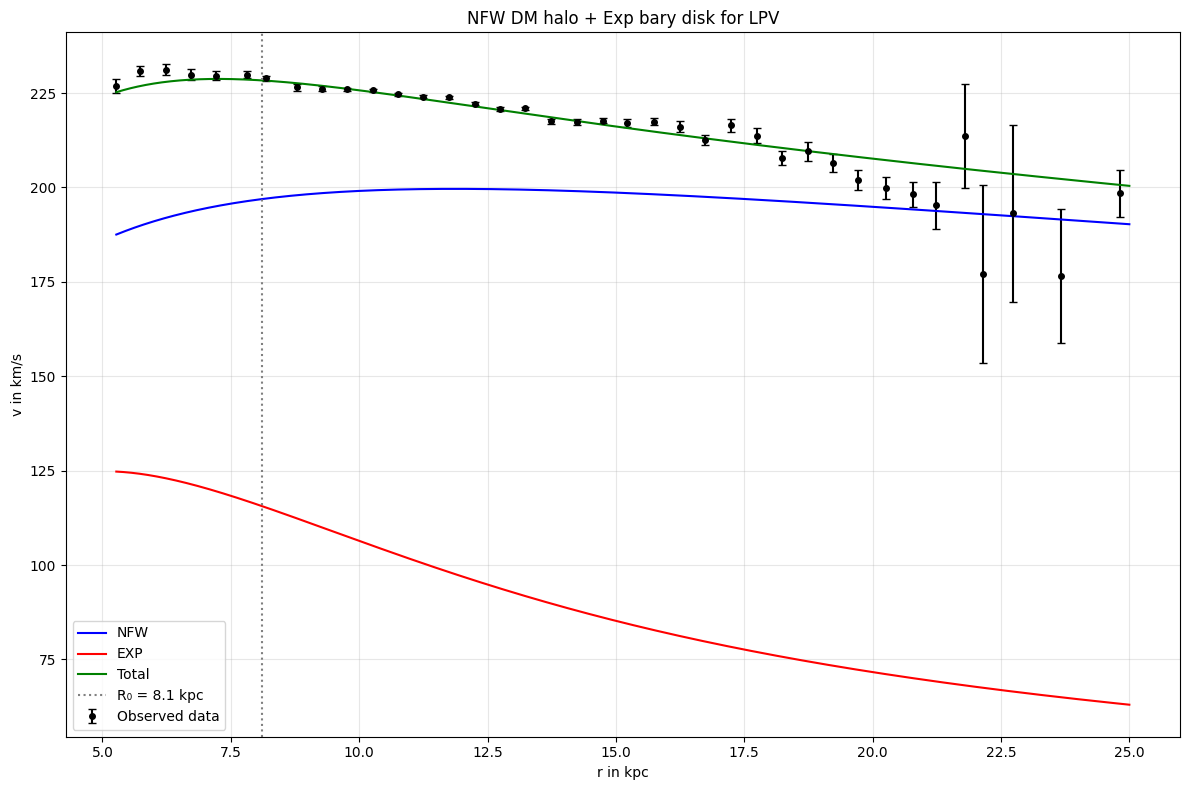

In [5]:
# Load the data
data = np.loadtxt('Eilers_data.txt')  # Skip the header row

# Extract the columns
r_data = data[:, 0]  # Radius in kpc
v_data = data[:, 1]  # Velocity in km/s
v_err = data[:, 2]   # Velocity error in km/s

# Filter out rows with missing velocity data
valid_data = ~np.isnan(v_data)
r_data = r_data[valid_data]
v_data = v_data[valid_data]
v_err = v_err[valid_data]

# First, let's plot several model curves with different parameters
plt.figure(figsize=(12, 8))
plt.errorbar(r_data, v_data, yerr=v_err, fmt='o', color='black', 
             markersize=4, capsize=3, label='Observed data')

# These parameters seem to be from a previous fit
[Rho_sun, Rs, sigma_sun, Rb] = best_fit   
# [Rho_sun, Rs, sigma_sun, Rb] = [0.15046073,60.98004726,50.48576643,1.63244565]
              

r_model = np.linspace(np.min(r_data), 25, 1000)

# Calculate the model components directly
v_dark = v_NFW(Rho_sun, Rs, r_model)
v_bary = v_EXP(sigma_sun, Rb, r_model)
v_tot = np.sqrt(v_dark**2 + v_bary**2)

# For mock data generation (if needed)
v_err_mock = 0.05 * v_tot
v_noise = np.random.normal(0, v_err_mock)
v_final = v_tot + v_noise

# Plot everything
plt.plot(r_model, v_dark, c='b', label='NFW')
plt.plot(r_model, v_bary, c='r', label='EXP')
plt.plot(r_model, v_tot, c='g', label='Total')
#plt.errorbar(r_model, v_final, v_err_mock, c='g', fmt='.', capsize=2, elinewidth=0.5, label='mock RC data')

# Add the linear approximation
R0 = 8.1  # kpc
v0 = 229.0  # km/s
slope = -1.7  # km/s/kpc
v_linear = v0 + slope * (r_model - R0)

# Add to your plotting section
#plt.plot(r_model, v_linear, c='purple', linestyle='--', 
         #label=f'Linear model: v₀={v0}, slope={slope}')

# Add a vertical line at R0
plt.axvline(x=R0, color='gray', linestyle=':', label='R₀ = 8.1 kpc')

# Annotate key parameters on the plot
# plt.annotate(f'NFW: log₁₀ρₛ={logRhos:.2f}, Rₛ={Rs:.2f}', 
#              xy=(0.05, 0.95), xycoords='axes fraction',
#              bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
# plt.annotate(f'EXP: log₁₀Σ={logSigmab:.2f}, Rb={Rb:.2f}', 
#              xy=(0.05, 0.90), xycoords='axes fraction',
#              bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.legend()
plt.xlabel('r in kpc')
#plt.xlim(5, 25)
plt.ylabel('v in km/s')
plt.title('NFW DM halo + Exp bary disk for LPV')
plt.grid(True, alpha=0.3)
plt.tight_layout()

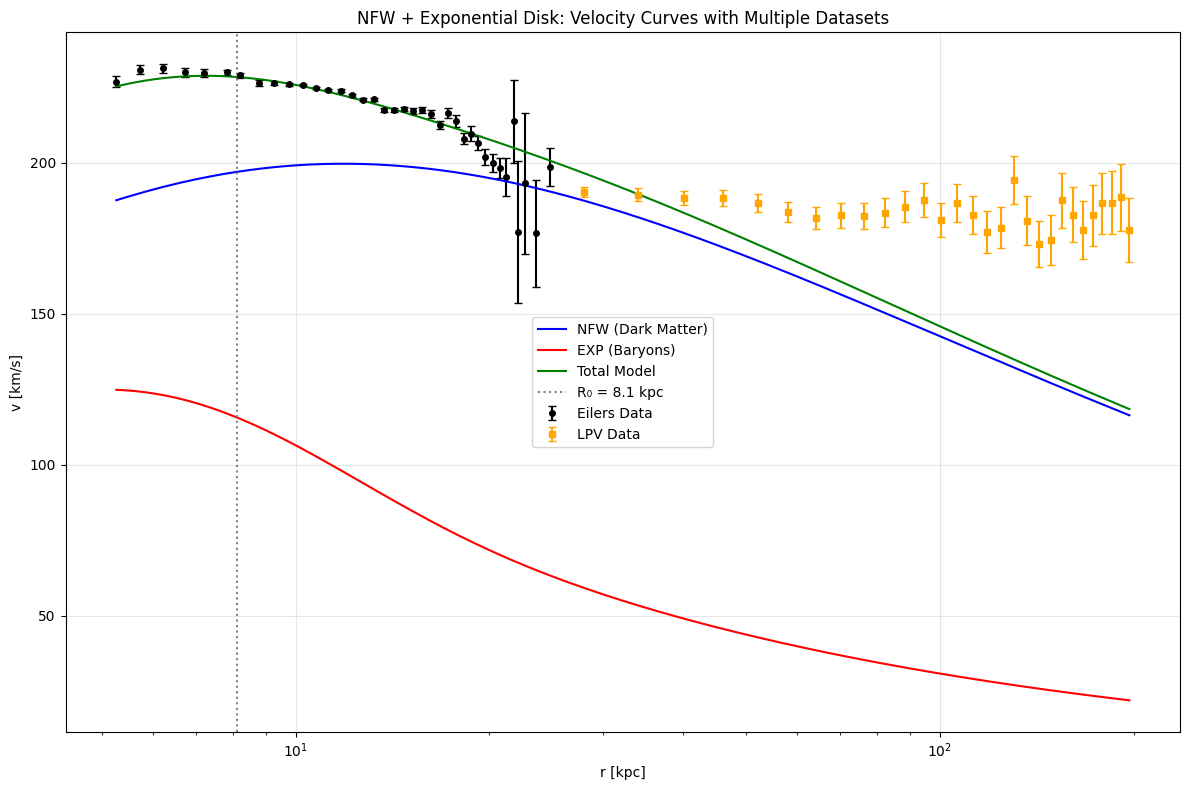

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Load both datasets
data1 = np.loadtxt('Eilers_data.txt')
data2 = np.loadtxt('LPV_Gaia_8.1_229_30.txt')  # Replace with actual filename

# Extract columns
r1, v1, verr1 = data1[:, 0], data1[:, 1], data1[:, 2]
r2, v2, verr2 = data2[:, 0], data2[:, 1], data2[:, 2]

# Remove NaNs
valid1 = ~np.isnan(v1)
valid2 = ~np.isnan(v2)
r1, v1, verr1 = r1[valid1], v1[valid1], verr1[valid1]
r2, v2, verr2 = r2[valid2], v2[valid2], verr2[valid2]

# Combine all radii for total radial range
r_all = np.concatenate((r1, r2))
r_min, r_max = np.min(r_all), np.max(r_all)

# Plotting
plt.figure(figsize=(12, 8))

# Plot both datasets
plt.errorbar(r1, v1, yerr=verr1, fmt='o', color='black', markersize=4, capsize=3, label='Eilers Data')
plt.errorbar(r2, v2, yerr=verr2, fmt='s', color='orange', markersize=4, capsize=3, label='LPV Data')

# Best-fit parameters
#best_fit = [0.46078194,5.86052428,22.17387812,2.35112233]
#best_fit = [0.47382466741657103, 2.9381614341509947, 34.524118835156166, 10.7423353979051]
rhoDM_sun, Rs, sigma_sun, Rb = best_fit

# Generate model over the full range
r_model = np.linspace(r_min, r_max, 1000)
v_dark = v_NFW(rhoDM_sun, Rs, r_model)
v_bary = v_EXP(sigma_sun, Rb, r_model)
v_tot = np.sqrt(v_dark**2 + v_bary**2)

# Plot models
plt.plot(r_model, v_dark, 'b-', label='NFW (Dark Matter)')
plt.plot(r_model, v_bary, 'r-', label='EXP (Baryons)')
plt.plot(r_model, v_tot, 'g-', label='Total Model')

# Optional: vertical line at Solar radius
plt.axvline(x=8.1, color='gray', linestyle=':', label='R₀ = 8.1 kpc')

# Labels and grid
plt.xlabel('r [kpc]')
plt.ylabel('v [km/s]')
plt.title('NFW + Exponential Disk: Velocity Curves with Multiple Datasets')
plt.legend()
plt.xscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

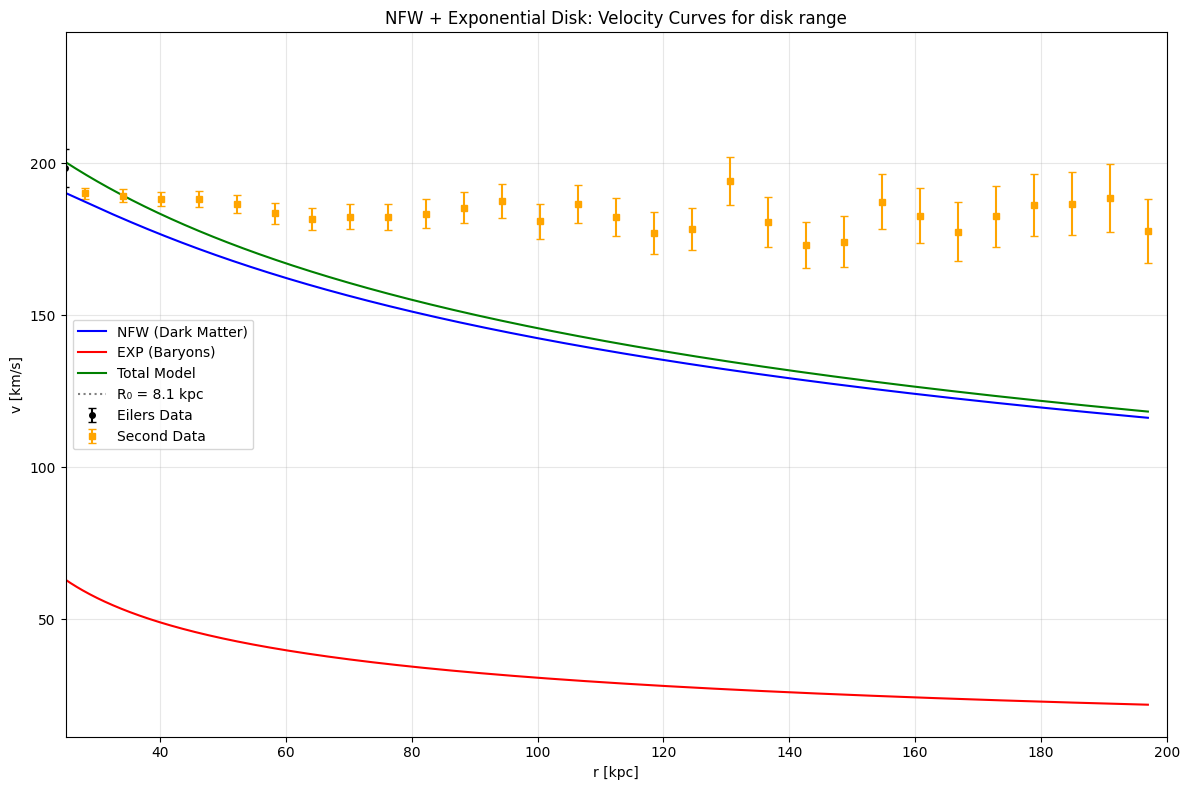

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Load both datasets
data1 = np.loadtxt('Eilers_data.txt')
data2 = np.loadtxt('LPV_Gaia_8.1_229_30.txt')  # Replace with actual filename

# Extract columns
r1, v1, verr1 = data1[:, 0], data1[:, 1], data1[:, 2]
r2, v2, verr2 = data2[:, 0], data2[:, 1], data2[:, 2]

# Remove NaNs
valid1 = ~np.isnan(v1)
valid2 = ~np.isnan(v2)
r1, v1, verr1 = r1[valid1], v1[valid1], verr1[valid1]
r2, v2, verr2 = r2[valid2], v2[valid2], verr2[valid2]

# Combine all radii for total radial range
r_all = np.concatenate((r1, r2))
r_min, r_max = np.min(r_all), np.max(r_all)

# Plotting
plt.figure(figsize=(12, 8))

# Plot both datasets
plt.errorbar(r1, v1, yerr=verr1, fmt='o', color='black', markersize=4, capsize=3, label='Eilers Data')
plt.errorbar(r2, v2, yerr=verr2, fmt='s', color='orange', markersize=4, capsize=3, label='Second Data')

# Best-fit parameters
rhoDM_sun, Rs, sigma_sun, Rb = best_fit

# Generate model over the full range
r_model = np.linspace(r_min, r_max, 1000)
v_dark = v_NFW(rhoDM_sun, Rs, r_model)
v_bary = v_EXP(sigma_sun, Rb, r_model)
v_tot = np.sqrt(v_dark**2 + v_bary**2)

# Plot models
plt.plot(r_model, v_dark, 'b-', label='NFW (Dark Matter)')
plt.plot(r_model, v_bary, 'r-', label='EXP (Baryons)')
plt.plot(r_model, v_tot, 'g-', label='Total Model')

# Optional: vertical line at Solar radius
plt.axvline(x=8.1, color='gray', linestyle=':', label='R₀ = 8.1 kpc')

# Labels and grid
plt.xlabel('r [kpc]')
plt.ylabel('v [km/s]')
plt.title('NFW + Exponential Disk: Velocity Curves for disk range')
plt.legend()
#plt.xscale('log')
plt.xlim(25, 200)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


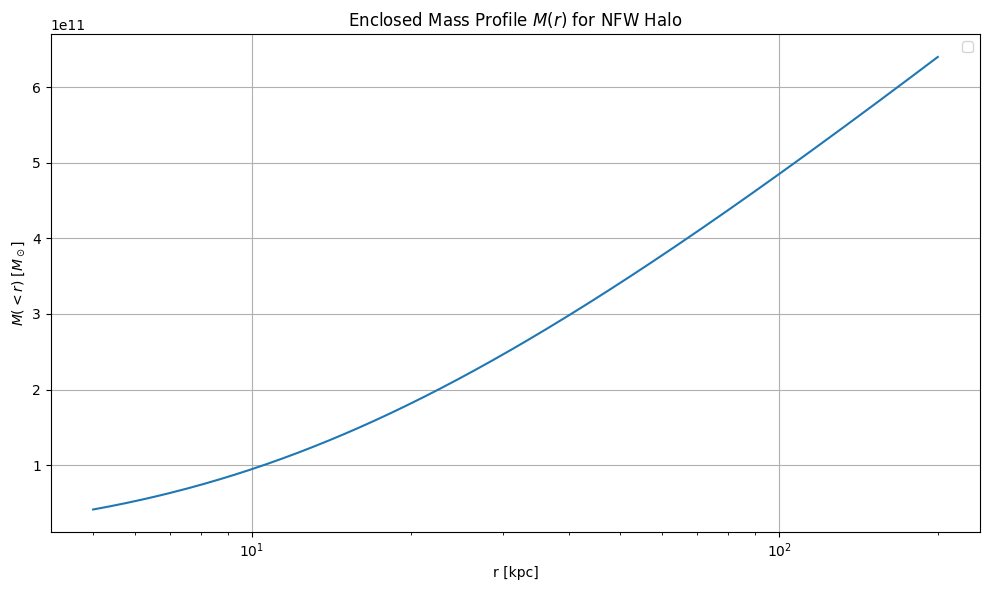

In [12]:
#code to obtain the M(r) profile for the NFW halo

import numpy as np
import matplotlib.pyplot as plt

GeVcm3_to_Msunkpc3 = 2.685e7  # GeV/cm^3 to M_sun/kpc^3
R_sun = 8.1  # kpc

# --- Best-fit parameter sets: [rhoDM_sun, Rs, sigma_sun, Rb] ---
Rho_sun, Rs, sigma_sun, Rb = best_fit

# --- Enclosed mass function from NFW profile ---
def m_NFW(Rho_sun, Rs, r):
    """Enclosed mass for NFW profile."""
    Rhos = (Rho_sun * GeVcm3_to_Msunkpc3) * (R_sun / Rs) * (1 + (R_sun / Rs))**2
    gr = np.log(np.maximum((Rs + r) / Rs, 1e-10)) - (r / (Rs + r + 1e-10))
    return 4.0 * np.pi * Rhos * gr * Rs**3  # in M_sun

# --- Radius range ---
r_vals = np.linspace(5, 200, 1000)

# --- Plotting ---
plt.figure(figsize=(10, 6))

m_vals = m_NFW(Rho_sun, Rs, r_vals)
plt.plot(r_vals, m_vals)

plt.xlabel('r [kpc]')
plt.ylabel(r'$M(<r)$ [$M_\odot$]')
plt.title('Enclosed Mass Profile $M(r)$ for NFW Halo')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.tight_layout()
plt.show()

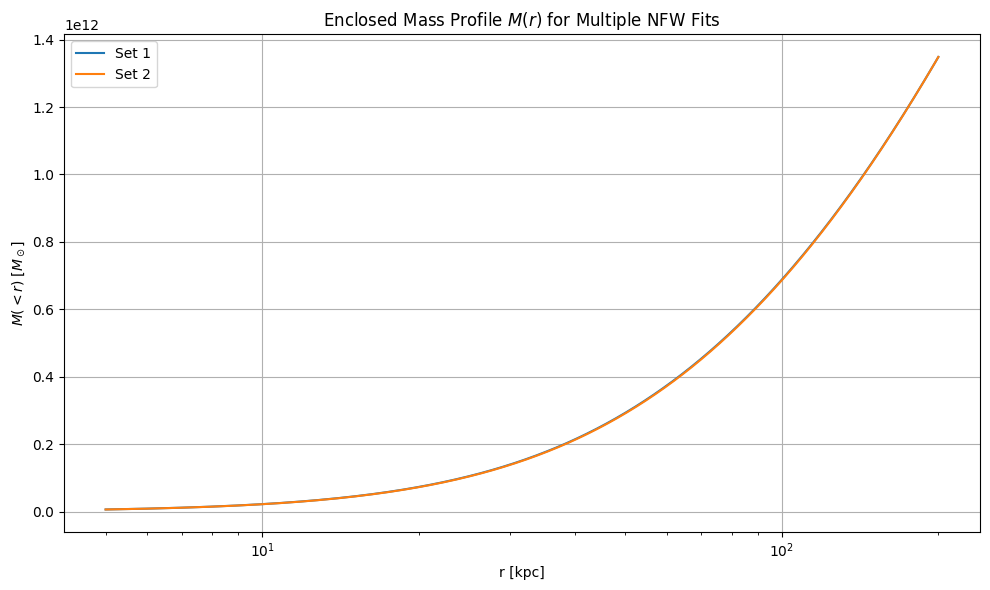

In [9]:
#code to obtain the M(r) profile for the NFW halo with multiple fits and compare them

import numpy as np
import matplotlib.pyplot as plt

GeVcm3_to_Msunkpc3 = 2.685e7  # GeV/cm^3 to M_sun/kpc^3
R_sun = 8.1  # kpc

# --- Best-fit parameter sets: [rhoDM_sun, Rs, sigma_sun, Rb] ---
best_fits = [
    [0.15244989,60.08014668,69.04154341,1.85273859]
    ,[0.15087073,60.76931729,50.50683412,1.63413062]
]

# --- Enclosed mass function from NFW profile ---
def m_NFW(Rho_sun, Rs, r):
    """Enclosed mass for NFW profile."""
    Rhos = (Rho_sun * GeVcm3_to_Msunkpc3) * (R_sun / Rs) * (1 + (R_sun / Rs))**2
    gr = np.log(np.maximum((Rs + r) / Rs, 1e-10)) - (r / (Rs + r + 1e-10))
    return 4.0 * np.pi * Rhos * gr * Rs**3  # in M_sun

# --- Radius range ---
r_vals = np.linspace(5, 200, 1000)

# --- Plotting ---
plt.figure(figsize=(10, 6))

for i, (Rho_sun, Rs, Sigma, Rb) in enumerate(best_fits):
    m_vals = m_NFW(Rho_sun, Rs, r_vals)
    label = f'Set {i+1}'
    plt.plot(r_vals, m_vals, label=label)

plt.xlabel('r [kpc]')
plt.ylabel(r'$M(<r)$ [$M_\odot$]')
plt.title('Enclosed Mass Profile $M(r)$ for Multiple NFW Fits')
plt.legend()
plt.xscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()


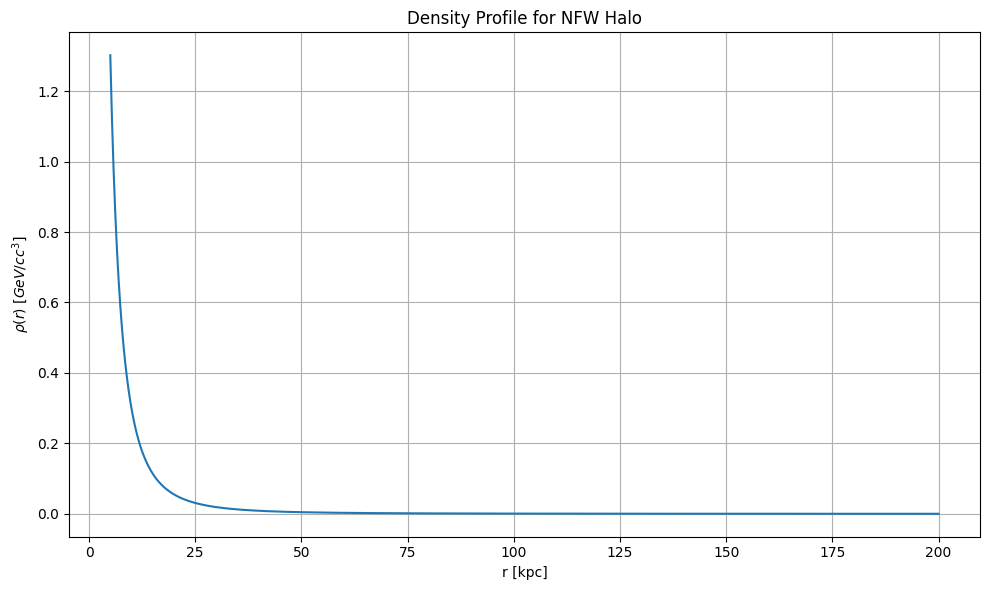

In [13]:
#Code for density profile of the NFW halo
import numpy as np
import matplotlib.pyplot as plt

def rho_dm(Rho_sun, Rs, r):
    """Density profile for NFW halo."""
    Rhos = (Rho_sun) * (R_sun / Rs) * (1 + (R_sun / Rs))**2
    return Rhos / ((r / Rs) * (1 + r / Rs)**2)  # in M_sun/kpc^3

Rho_sun, Rs, sigma_sun, Rb = best_fit
r_vals = np.linspace(5, 200, 1000)
plt.figure(figsize=(10, 6))
plt.plot(r_vals, rho_dm(Rho_sun, Rs, r_vals), label='Density Profile for NFW Halo')
plt.xlabel('r [kpc]')   
plt.ylabel(r'$\rho(r)$ [$GeV/cc^3$]')
plt.title('Density Profile for NFW Halo')
plt.grid(True)
#plt.xscale('log')
plt.tight_layout()
plt.show()

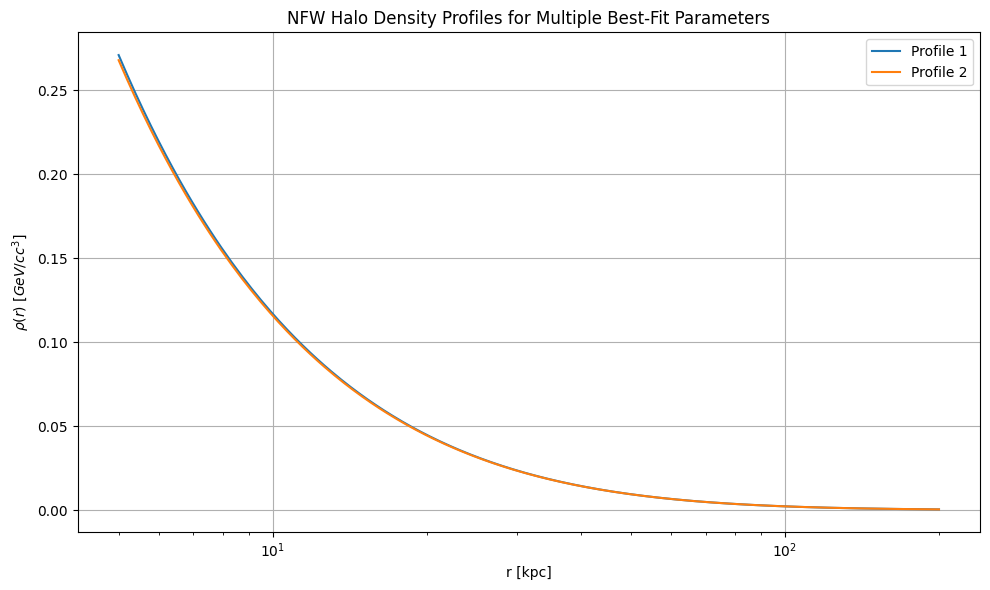

In [11]:
#Code for DM density profile for multiple data sets and compare them

import numpy as np
import matplotlib.pyplot as plt

# NFW density function
def rho_dm(Rho_sun, Rs, r):
    """Density profile for NFW halo."""
    Rhos = (Rho_sun) * (R_sun / Rs) * (1 + (R_sun / Rs))**2
    return Rhos / ((r / Rs) * (1 + r / Rs)**2)  # in M_sun/kpc^3

# List of best-fit parameter sets
best_fits = [
    [0.15244989,60.08014668,69.04154341,1.85273859]
    ,[0.15087073,60.76931729,50.50683412,1.63413062]
]

r_vals = np.linspace(5, 200, 1000)  # Radius values in kpc

# Plotting
plt.figure(figsize=(10, 6))

for i, params in enumerate(best_fits):
    Rho_sun, Rs, sigma_sun, Rb = params
    density_profile = rho_dm(Rho_sun, Rs, r_vals)
    plt.plot(r_vals, density_profile, label=f'Profile {i + 1}')

plt.xlabel('r [kpc]')
plt.ylabel(r'$\rho(r)$ [$GeV/cc^3$]')
plt.title('NFW Halo Density Profiles for Multiple Best-Fit Parameters')
plt.grid(True)
plt.legend()
plt.xscale('log')
plt.tight_layout()
plt.show()
